Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2213 - val_loss: 0.0899
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0491 - val_loss: 0.0369
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0332 - val_loss: 0.0322
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0299 - val_loss: 0.0318
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300 - val_loss: 0.0333
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0301 - val_loss: 0.0294
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0261 - val_loss: 0.0284
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0255 - val_loss: 0.0243
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0234 - val_loss: 0.0310
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


/tmp/ipython-input-1-3951479186.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


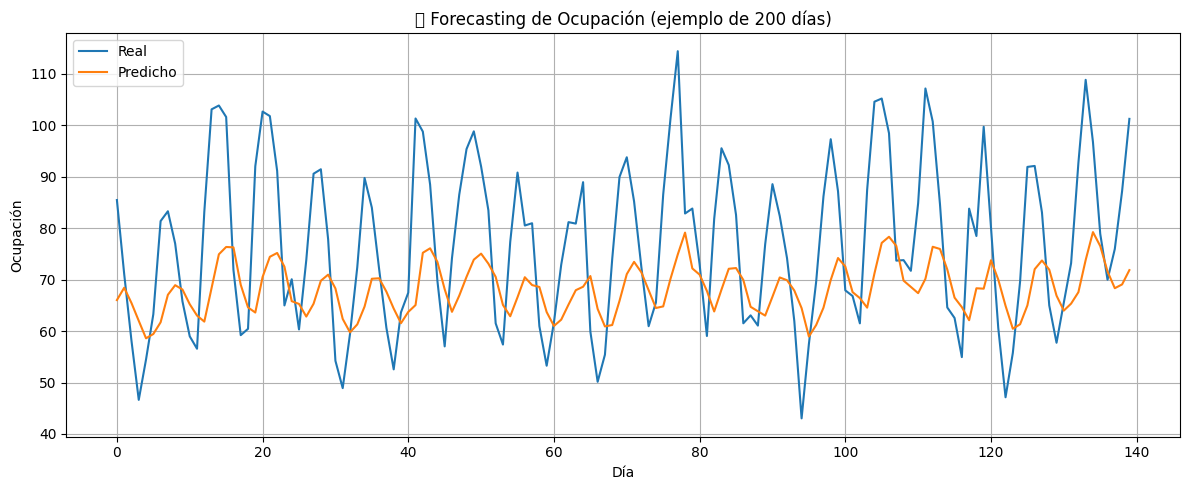

📊 RMSE: 16.69
📊 MAE : 13.66
🚨 Días con ocupación prevista alta (top 5%): 7
📅 Fechas de alta demanda previstas:
['2023-10-31T00:00:00.000000000' '2023-11-27T00:00:00.000000000'
 '2023-11-28T00:00:00.000000000' '2023-11-29T00:00:00.000000000'
 '2023-12-04T00:00:00.000000000' '2023-12-26T00:00:00.000000000'
 '2023-12-27T00:00:00.000000000']


In [1]:
# ✅ 0. INSTALACIÓN (solo si usas Google Colab)
!pip install -q tensorflow

# 📦 1. IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ================================
# 2️⃣ SIMULACIÓN DE DATOS
# ================================
np.random.seed(42)
n_days = 730  # 2 años
dates = pd.date_range(start="2022-01-01", periods=n_days, freq="D")

# Patrón realista: tendencia + estacionalidad + ruido
base = 50 + 20 * np.sin(2 * np.pi * np.arange(n_days) / 7)     # semanal
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_days) / 30)  # mensual
trend = np.linspace(0, 30, n_days)
noise = np.random.normal(0, 5, n_days)
occupancy = base + seasonality + trend + noise

df = pd.DataFrame({'date': dates, 'occupancy': occupancy})

# ================================
# 3️⃣ NORMALIZACIÓN
# ================================
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['occupancy']])

# ================================
# 4️⃣ CREACIÓN DE SECUENCIAS
# ================================
def create_sequences(series, window=30):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 30
series = df['scaled'].values
X, y = create_sequences(series, window_size)

# ================================
# 5️⃣ SPLIT TRAIN / TEST
# ================================
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================
# 6️⃣ MODELO LSTM
# ================================
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train[..., np.newaxis], y_train,
          epochs=10, batch_size=32, validation_split=0.1)

# ================================
# 7️⃣ PREDICCIÓN Y EVALUACIÓN
# ================================
y_pred = model.predict(X_test[..., np.newaxis])
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

# ================================
# 8️⃣ VISUALIZACIÓN DEL FORECAST
# ================================
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label="Real")
plt.plot(y_pred_inv[:200], label="Predicho")
plt.title("📈 Forecasting de Ocupación (ejemplo de 200 días)")
plt.xlabel("Día")
plt.ylabel("Ocupación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# 9️⃣ DETECCIÓN DE ALTA DEMANDA (Anomalías)
# ================================
threshold = np.percentile(y_pred_inv, 95)  # top 5% como anomalías
anomalies = y_pred_inv.flatten() > threshold
anomaly_days = df.iloc[-len(y_pred_inv):]['date'].reset_index(drop=True)[anomalies]

# ================================
# 🔍 RESULTADOS
# ================================
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE : {mae:.2f}")
print(f"🚨 Días con ocupación prevista alta (top 5%): {len(anomaly_days)}")
print("📅 Fechas de alta demanda previstas:")
print(anomaly_days.values)


/tmp/ipython-input-2-1562785113.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


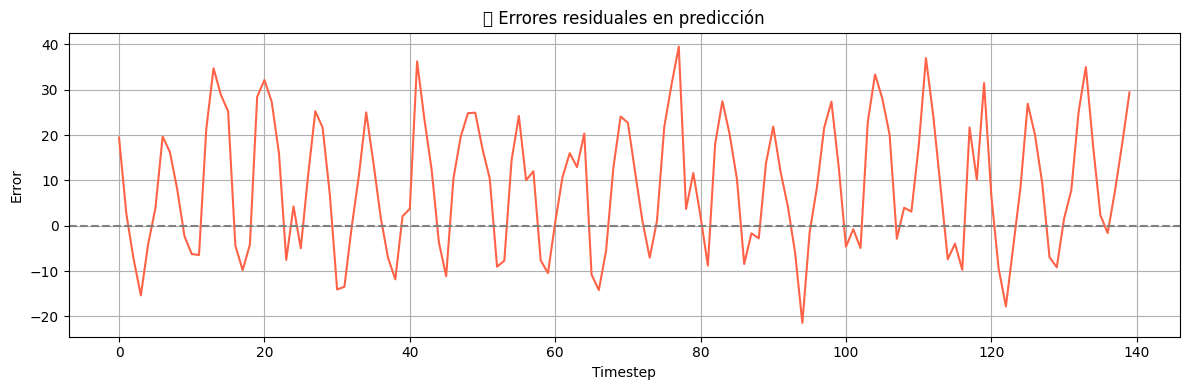

📌 MAPE (Error porcentual medio): 16.76%


/tmp/ipython-input-2-1562785113.py:33: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


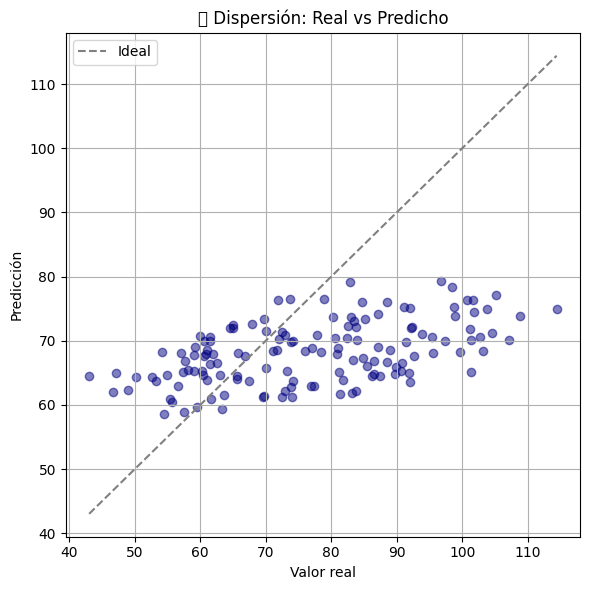

/tmp/ipython-input-2-1562785113.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


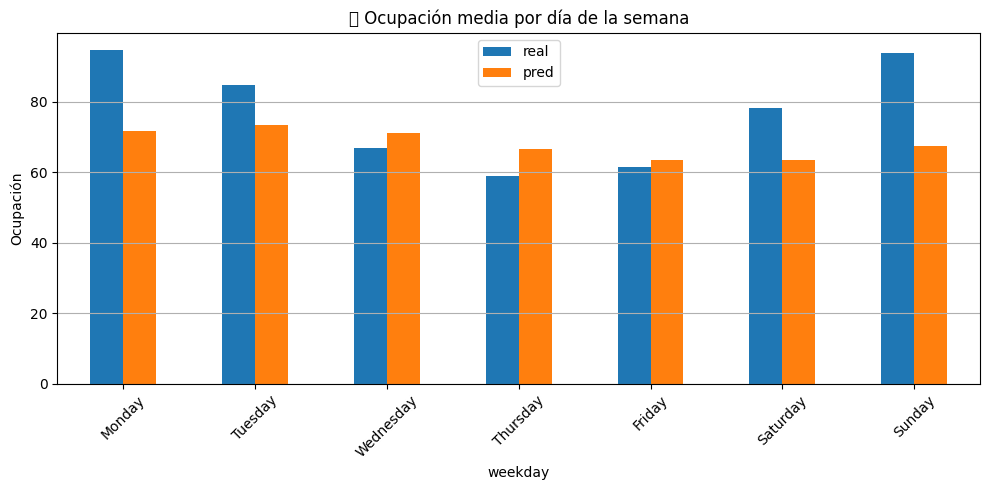

In [2]:
# ================================
# 🔍 Evaluación avanzada del forecast
# ================================

# 1. Errores residuales
errors = y_test_inv.flatten() - y_pred_inv.flatten()
abs_errors = np.abs(errors)
mape = np.mean(abs_errors / y_test_inv.flatten()) * 100

plt.figure(figsize=(12, 4))
plt.plot(errors[:200], label="Error de predicción", color="tomato")
plt.axhline(0, linestyle="--", color="gray")
plt.title("📉 Errores residuales en predicción")
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📌 MAPE (Error porcentual medio): {mape:.2f}%")

# 2. Real vs Predicho: dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5, color="navy")
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         linestyle='--', color='gray', label='Ideal')
plt.title("🎯 Dispersión: Real vs Predicho")
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Heatmap por día de la semana
forecast_dates = df.iloc[-len(y_pred_inv):]['date'].reset_index(drop=True)
df_forecast = pd.DataFrame({
    "date": forecast_dates,
    "real": y_test_inv.flatten(),
    "pred": y_pred_inv.flatten()
})
df_forecast['weekday'] = df_forecast['date'].dt.day_name()

weekly_stats = df_forecast.groupby('weekday')[['real', 'pred']].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

weekly_stats.plot(kind='bar', figsize=(10, 5))
plt.title("📊 Ocupación media por día de la semana")
plt.ylabel("Ocupación")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
